### Investigate if there's a potential feedback confound in the pref vs. not pref analysis
One result that looked suspiciously too good was this, when trying to decode whether the feature was preferred or not, conditioned on the feature being chosen: 
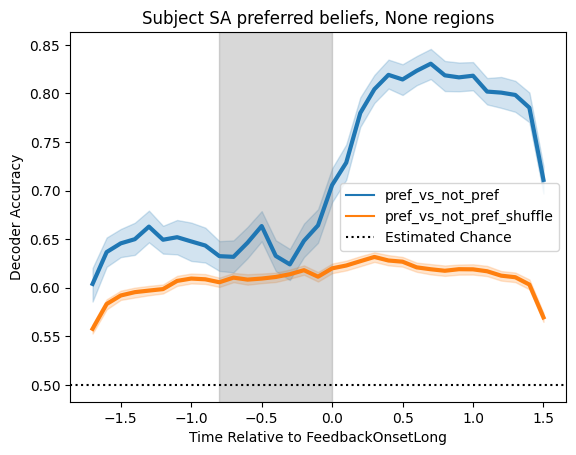
### To check the feedback confound:
- Look at correct to incorrect ratio, across the 3 conditions. chosen pref, chosen not pref, not chosen not pref
- Plot at distribution across sessions, features

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *

import seaborn as sns
import scipy.stats


In [2]:
num_bins = 2

def get_cor_ratios(row, beh_path, sub):
    session = row.sessions
    feat = row.feat
    behavior_path = beh_path.format(sess_name=session, sub=sub)
    beh = pd.read_csv(behavior_path)

    # # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, session, sub)
    beh = behavioral_utils.get_belief_value_labels(beh)
    pref_all = behavioral_utils.get_chosen_preferred_single(feat, beh)
    pref = pref_all[pref_all.Choice == feat]
    other = pref_all[pref_all.Choice == "other"]
    not_pref = behavioral_utils.get_chosen_not_preferred_single(feat, beh)
    not_pref = not_pref[not_pref.Choice == feat]
    pref_rat = len(pref[pref.Response == "Correct"]) / len(pref)
    not_pref_rat = len(not_pref[not_pref.Response == "Correct"]) / len(not_pref)
    other_rat = len(other[other.Response == "Correct"]) / len(other)
    return pd.Series({
        "session": session, 
        "feat": feat, 
        "chosen pref": pref_rat,
        "chosen not pref": not_pref_rat,
        "not chosen not pref": other_rat,
    })

In [3]:
SESSIONS_PATH = "/data/patrick_res/sessions/SA/valid_sessions.pickle"
FEATS_PATH = "/data/patrick_res/sessions/SA/feats_at_least_3blocks.pickle"

sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH

feat_sessions = pd.read_pickle(FEATS_PATH)
res = pd.DataFrame(feat_sessions.explode("sessions").apply(lambda x: get_cor_ratios(x, beh_path, "SA"), axis=1))


In [4]:
res

,session,feat,chosen pref,chosen not pref,not chosen not pref
0,20180615,CIRCLE,0.836735,0.489051,0.620614
0,20180625,CIRCLE,0.864865,0.559633,0.649874
0,20180709,CIRCLE,0.835443,0.502994,0.648208
0,20180802,CIRCLE,0.784946,0.512281,0.580696
0,20180803,CIRCLE,0.813953,0.459259,0.607207
...,...,...,...,...,...
11,20180828,SWIRL,0.882883,0.422460,0.607232
11,20180829,SWIRL,0.950617,0.413793,0.631687
11,20180904,SWIRL,0.923913,0.545918,0.634228
11,20180906,SWIRL,0.859155,0.500000,0.601361


In [6]:
melted = res.melt(id_vars=["session", "feat"], value_vars=["chosen pref", "chosen not pref", "not chosen not pref"], var_name="condition", value_name="correct ratio")

<Axes: xlabel='condition', ylabel='correct ratio'>

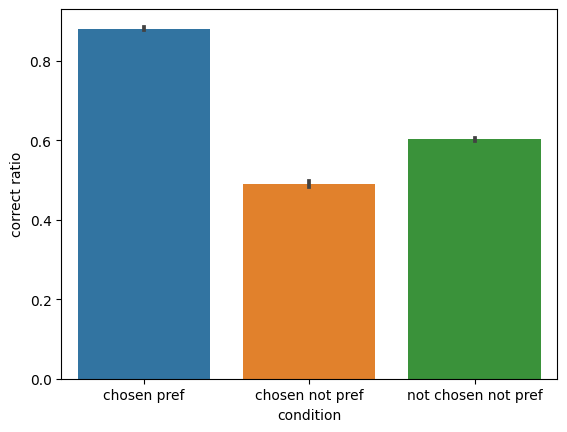

In [7]:
sns.barplot(melted, x="condition", y="correct ratio")

### Conclusion
- Need to be careful about feedback confound, there is definetly one here. 
- In detail: when the preferred feature matches a feature on the chosen card, the response is more likely to be correct. 
- Thus, comparing chosen pref vs. not chosen not pref and chosen not pref vs. not chosen not pref, 
- A decoder on the former could more take advantage of the response type
- TODO: Easiest would be to condition on feedback of correct. This shouldn't lose that many trials

### What if we only look at trials where the preferred feature falls onto the chosen card?

How does correct ratio of generally the preferred feature chosen compare to the feature we're trying to decode specifically chosen?

In [4]:
num_bins = 2

def get_cor_ratios(row, beh_path, sub):
    session = row.sessions
    feat = row.feat
    behavior_path = beh_path.format(sess_name=session, sub=sub)
    beh = pd.read_csv(behavior_path)

    # # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, session, sub)
    beh = behavioral_utils.get_belief_value_labels(beh)

    beh["PrefChosen"] = beh.apply(lambda x: x[FEATURE_TO_DIM[x.PreferredBelief]] == x.PreferredBelief, axis=1)
    beh = beh[beh.PrefChosen]
    pref_chosen_rat = len(beh[beh.Response == "Correct"]) / len(beh)

    pref_all = behavioral_utils.get_chosen_preferred_single(feat, beh)
    pref = pref_all[pref_all.Choice == feat]
    other = pref_all[pref_all.Choice == "other"]
    not_pref = behavioral_utils.get_chosen_not_preferred_single(feat, beh)
    not_pref = not_pref[not_pref.Choice == feat]
    pref_rat = len(pref[pref.Response == "Correct"]) / len(pref)
    not_pref_rat = len(not_pref[not_pref.Response == "Correct"]) / len(not_pref)
    other_rat = len(other[other.Response == "Correct"]) / len(other)
    return pd.Series({
        "session": session, 
        "feat": feat, 
        "general pref chosen": pref_chosen_rat,
        "chosen pref": pref_rat,
        "chosen not pref": not_pref_rat,
        "not chosen not pref": other_rat,
    })

In [5]:
res = pd.DataFrame(feat_sessions.explode("sessions").apply(lambda x: get_cor_ratios(x, beh_path, "SA"), axis=1))


<Axes: xlabel='condition', ylabel='correct ratio'>

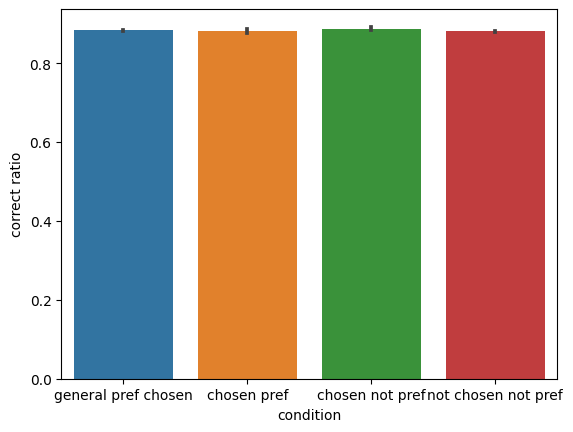

In [6]:
melted = res.melt(id_vars=["session", "feat"], value_vars=["general pref chosen", "chosen pref", "chosen not pref", "not chosen not pref"], var_name="condition", value_name="correct ratio")
sns.barplot(melted, x="condition", y="correct ratio")

What is the ratio (across all sessions) of generally the preferred feature getting chosen?

In [ ]:
sessions = pd.read_pickle(SESSIONS_PATH)
beh_path = SESS_BEHAVIOR_PATH

feat_sessions = pd.read_pickle(FEATS_PATH)


In [17]:
def pref_match_ratios(row, beh_path, sub):
    session = row.session_name
    behavior_path = beh_path.format(sess_name=session, sub=sub)
    beh = pd.read_csv(behavior_path)

    # # filter trials 
    beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(beh)
    beh = pd.merge(beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_beliefs_per_session(beh, session, sub)
    beh = behavioral_utils.get_belief_value_labels(beh)

    beh["PrefChosen"] = beh.apply(lambda x: x[FEATURE_TO_DIM[x.PreferredBelief]] == x.PreferredBelief, axis=1)
    general_pref_chosen = beh[beh.PrefChosen]

    return pd.Series({
        "session": session, 
        "pref_chosen_ratio": len(general_pref_chosen) / len(beh)
    })

In [18]:
res = pd.DataFrame(sessions.apply(lambda x: pref_match_ratios(x, beh_path, "SA"), axis=1))

<Axes: ylabel='pref_chosen_ratio'>

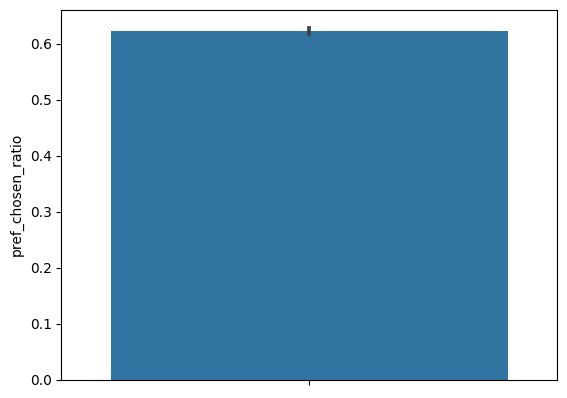

In [20]:
sns.barplot(res, y="pref_chosen_ratio")